<a href="https://colab.research.google.com/github/Muhammedesit/stock-prediction-projrct/blob/main/bioinformatics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jkwang93/AMP-Designer.git
!pip install biopython modlamp protlearn xgboost catboost scikit-learn --quiet


fatal: destination path 'AMP-Designer' already exists and is not an empty directory.


In [ ]:
import pandas as pd

amp_path = "/content/AMP-Designer/data/prompt_data/amp_data.csv"
non_amp_path = "/content/AMP-Designer/data/prompt_data/nonamp_data.csv"

df_amp = pd.read_csv(amp_path, header=None, names=["sequence"])
df_non_amp = pd.read_csv(non_amp_path, header=None, names=["sequence"])

df_amp["label"] = 1
df_non_amp["label"] = 0

df_all = pd.concat([df_amp, df_non_amp], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all = df_all[["sequence", "label"]]


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def extract_basic_features(seq):
    try:
        analysis = ProteinAnalysis(seq)
        return {
            "length": len(seq),
            "molecular_weight": analysis.molecular_weight(),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "isoelectric_point": analysis.isoelectric_point(),
            "gravy": analysis.gravy()
        }
    except:
        return {
            "length": 0, "molecular_weight": 0,
            "aromaticity": 0, "instability_index": 0,
            "isoelectric_point": 0, "gravy": 0
        }

features = df_all["sequence"].apply(extract_basic_features)
features_df = pd.DataFrame(features.tolist())
df_features = pd.concat([features_df, df_all["label"]], axis=1)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, matthews_corrcoef
import numpy as np

def evaluate_model(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {
        "accuracy": [], "f1": [], "auc": [],
        "mcc": [], "sensitivity": [], "specificity": []
    }

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["auc"].append(roc_auc_score(y_test, y_prob))
        metrics["mcc"].append(matthews_corrcoef(y_test, y_pred))
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)

    return {k: np.mean(v) for k, v in metrics.items()}


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

X = df_features.drop("label", axis=1)
y = df_features["label"]

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining: {name}")
    metrics = evaluate_model(model, X, y)
    results[name] = metrics



Training: Random Forest

Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training: AdaBoost

Training: CatBoost

Training: SVM


               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.820477  0.785747  0.894967  0.307197     0.942906   
XGBoost        0.817936  0.770347  0.893560  0.294732     0.942097   
AdaBoost       0.812034  0.727951  0.893667  0.175197     0.973727   
CatBoost       0.824576  0.780906  0.899084  0.288737     0.963318   
SVM            0.811214  0.507516  0.895768  0.000000     1.000000   

               specificity  
Random Forest     0.294383  
XGBoost           0.284402  
AdaBoost          0.117236  
CatBoost          0.228392  
SVM               0.000000  


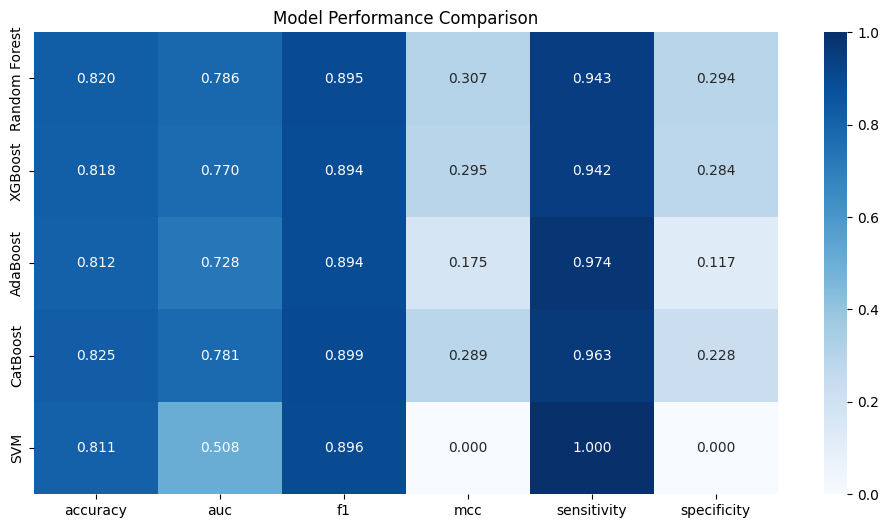

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results).T
results_df = results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison")
print(results_df)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-54-2cb1d3676b4d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")


             Feature  Importance
4  isoelectric_point    0.251475
0             length    0.187980
1   molecular_weight    0.158343
5              gravy    0.144563
2        aromaticity    0.142815
3  instability_index    0.114825


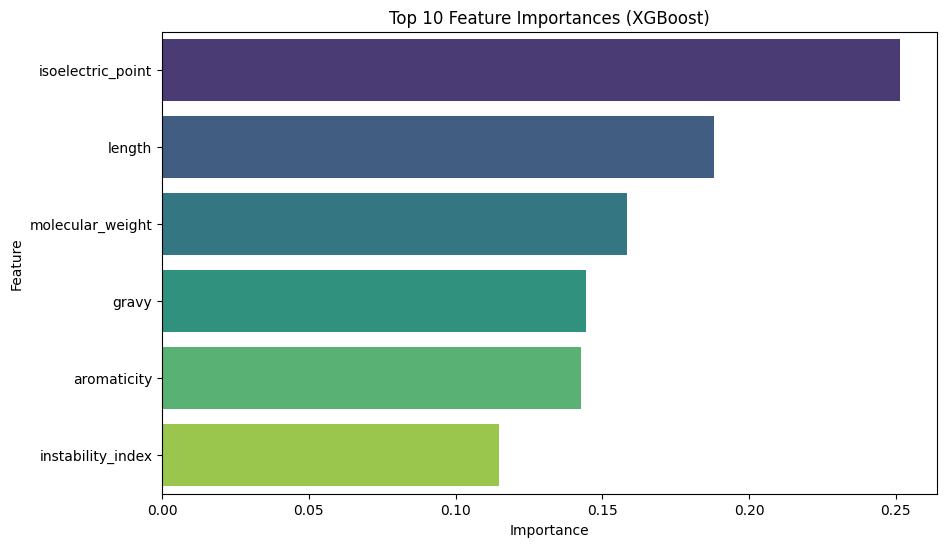

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X, y)

importances = xgb_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
print(importance_df)
plt.show()


Top 5 Selected Features: ['length', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point']

Training with reduced features: Random Forest

Training with reduced features: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training with reduced features: AdaBoost

Training with reduced features: CatBoost

Training with reduced features: SVM
               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.815886  0.764275  0.892063  0.292326     0.937853   
XGBoost        0.817280  0.753574  0.893489  0.284979     0.944725   
AdaBoost       0.812853  0.717174  0.894097  0.181906     0.973929   
CatBoost       0.822035  0.765730  0.898146  0.264469     0.967260   
SVM            0.811214  0.508976  0.895768  0.000000     1.000000   

               specificity  
Random Forest     0.291778  
XGBoost           0.269647  
AdaBoost          0.120709  
CatBoost          0.197998  
SVM               0.000000  


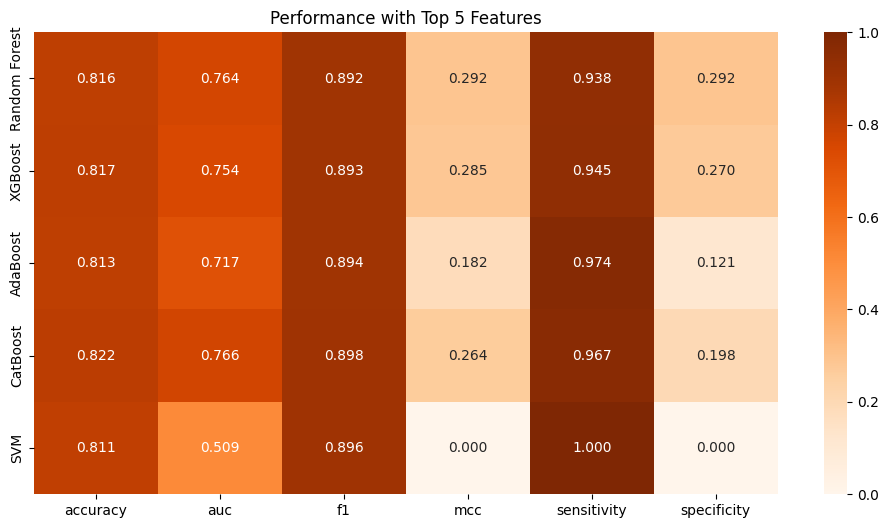

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Top 5 Selected Features:", selected_features.tolist())

X_reduced = X[selected_features]

reduced_results = {}
for name, model in models.items():
    print(f"\nTraining with reduced features: {name}")
    metrics = evaluate_model(model, X_reduced, y)
    reduced_results[name] = metrics

reduced_df = pd.DataFrame(reduced_results).T
reduced_df = reduced_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(reduced_df, annot=True, cmap="Oranges", fmt=".3f")
plt.title("Performance with Top 5 Features")
print(reduced_df)
plt.show()


In [ ]:
# LLM_classifier reposunu klonla (Dataset 2)
!git clone https://github.com/reymond-group/LLM_classifier.git

fatal: destination path 'LLM_classifier' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import json

from sklearn.model_selection import train_test_split

#### Import data

Read files

In [ ]:
activity = pd.read_csv('LLM_classifier/GPT-3_deprecated/data/fine_tune_activity.csv', usecols=['Sequence', 'activity', 'Set'])
hemolysis = pd.read_csv('LLM_classifier/GPT-3_deprecated/data/fine_tune_hemolysis.csv', usecols=['Sequence', 'isNotHemolytic', 'Set'])
hemolysis = hemolysis[(hemolysis['isNotHemolytic'] == 0) | (hemolysis['isNotHemolytic'] == 1)]

Rename columns

In [ ]:
activity = activity.rename(columns={'Sequence': 'sequence', 'activity': 'label', 'Set': 'split_1'})
hemolysis = hemolysis.rename(columns={'Sequence': 'sequence', 'isNotHemolytic': 'label', 'Set': 'split_1'})

Shuffle data

In [ ]:
activity = activity.sample(frac=1, random_state=42).reset_index(drop=True)
hemolysis = hemolysis.sample(frac=1, random_state=42).reset_index(drop=True)

Add columns with four additional test/train splits (for cross-validation).

In [ ]:
def generate_splits(df):
    train_splits = {}
    test_splits = {}
    for i in range(2, 6):
        train_splits[i], test_splits[i] = train_test_split(df.index, test_size=0.25, random_state=i)
        df[f'split_{i}'] = 'training'
        df.loc[test_splits[i], f'split_{i}'] = 'test'

generate_splits(activity)
generate_splits(hemolysis)

Export datasets

In [ ]:
activity.to_csv('LLM_classifier/GPT-3_deprecated/data/activity_clean.csv', index=False)
hemolysis.to_csv('LLM_classifier/GPT-3_deprecated/data/hemolysis_clean.csv', index=False)

#### Generate datasets for GPT-3.5 Turbo fine-tuning

Define function to write data from dataframe to file in the correct format

In [ ]:
def write_json(df, purpose, filename):
    with open(filename, 'w') as f:
        for index, row in df.iterrows():

            sequence = row['sequence'] + ' ->'
            label = row['label']

            system_role = {"role": "system", "content": f"You are a model that predicts {purpose} from an amino acid sequence."}
            user_message = {"role": "user", "content": str(sequence)}
            system_message = {"role": "assistant", "content": str(label)}

            messages = []
            messages.append(system_role)
            messages.append(user_message)
            messages.append(system_message)
            data = {"messages": messages}

            f.write(json.dumps(data) + '\n')

Loop through each of the five splits and write the data to files

In [ ]:
for i in range(1, 6):
    write_json(activity[activity[f'split_{i}'] == 'training'], 'activity', f'LLM_classifier/GPT-3_deprecated/data/activity_train_{i}.json')
    write_json(activity[activity[f'split_{i}'] == 'test'], 'activity', f'LLM_classifier/GPT-3_deprecated/data/activity_test_{i}.json')
    write_json(hemolysis[hemolysis[f'split_{i}'] == 'training'], 'hemolysis', f'LLM_classifier/GPT-3_deprecated/data/hemolysis_train_{i}.json')
    write_json(hemolysis[hemolysis[f'split_{i}'] == 'test'], 'hemolysis', f'LLM_classifier/GPT-3_deprecated/data/hemolysis_test_{i}.json')

In [ ]:
!pip install biopython modlamp protlearn xgboost catboost scikit-learn --quiet


In [ ]:
import pandas as pd

df_llm = pd.read_csv("LLM_classifier/GPT-3_deprecated/data/activity_clean.csv")
df_llm = df_llm[["sequence", "label"]]  # Sadece gerekli sütunları al
df_llm = df_llm.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def extract_basic_features(seq):
    try:
        analysis = ProteinAnalysis(seq)
        return {
            "length": len(seq),
            "molecular_weight": analysis.molecular_weight(),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "isoelectric_point": analysis.isoelectric_point(),
            "gravy": analysis.gravy()
        }
    except:
        return {
            "length": 0, "molecular_weight": 0,
            "aromaticity": 0, "instability_index": 0,
            "isoelectric_point": 0, "gravy": 0
        }

features_llm = df_llm["sequence"].apply(extract_basic_features)
features_llm_df = pd.DataFrame(features_llm.tolist())
df_llm_features = pd.concat([features_llm_df, df_llm["label"]], axis=1)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, matthews_corrcoef
import numpy as np

def evaluate_model(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {"accuracy": [], "f1": [], "auc": [], "mcc": [], "sensitivity": [], "specificity": []}

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["auc"].append(roc_auc_score(y_test, y_prob))
        metrics["mcc"].append(matthews_corrcoef(y_test, y_pred))
        metrics["sensitivity"].append(tp / (tp + fn))
        metrics["specificity"].append(tn / (tn + fp))

    return {k: np.mean(v) for k, v in metrics.items()}


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

X = df_llm_features.drop("label", axis=1)
y = df_llm_features["label"]

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining: {name}")
    metrics = evaluate_model(model, X, y)
    results[name] = metrics



Training: Random Forest

Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training: AdaBoost

Training: CatBoost

Training: SVM


               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.638878  0.701210  0.650828  0.278445     0.673022   
XGBoost        0.665061  0.716965  0.681008  0.331839     0.715125   
AdaBoost       0.670298  0.718312  0.706761  0.351745     0.794724   
CatBoost       0.687265  0.742218  0.716278  0.382634     0.789485   
SVM            0.552261  0.588282  0.583238  0.105820     0.626936   

               specificity  
Random Forest     0.604740  
XGBoost           0.615001  
AdaBoost          0.545876  
CatBoost          0.585048  
SVM               0.477588  


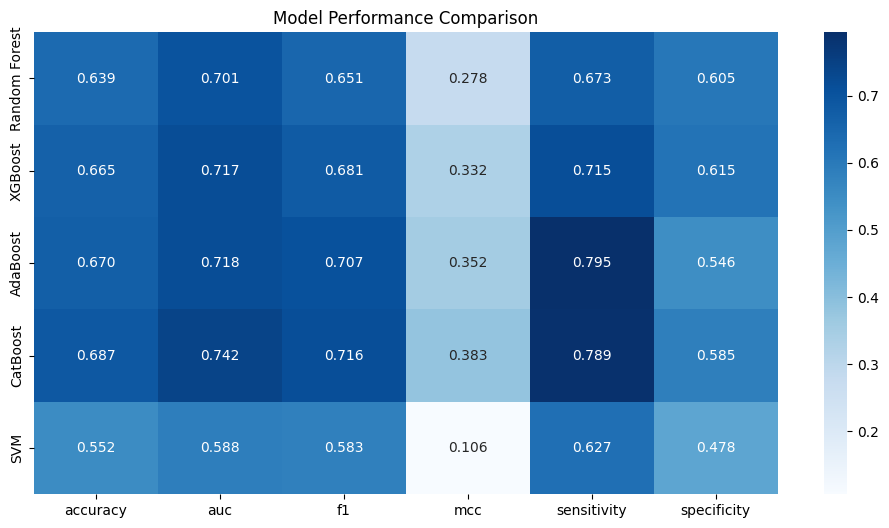

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison")
print(results_df)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


             Feature  Importance
4  isoelectric_point    0.360947
1   molecular_weight    0.152004
2        aromaticity    0.124997
0             length    0.123164
5              gravy    0.122144
3  instability_index    0.116743


<ipython-input-71-80e508d7ea6b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")


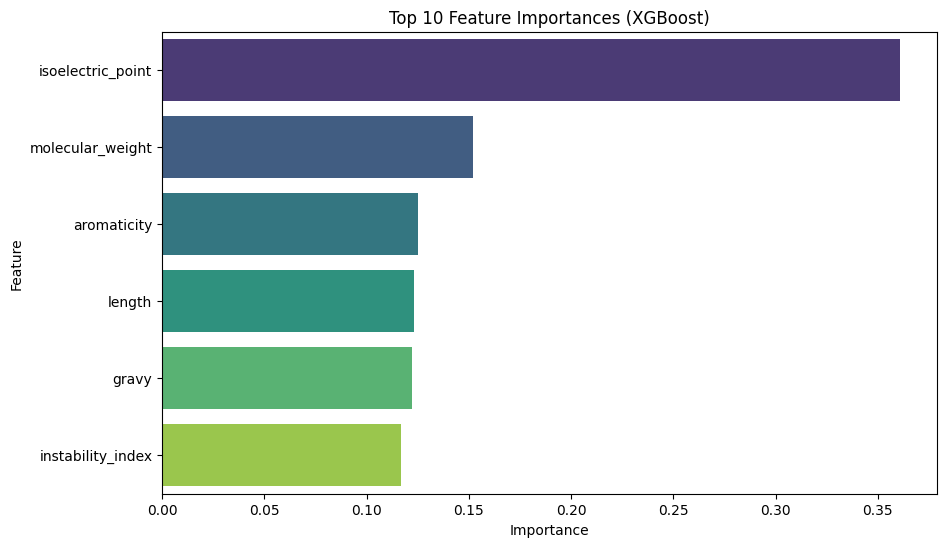

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X, y)

importances = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
print(importance_df)
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Top 5 Selected Features:", selected_features.tolist())


Top 5 Selected Features: ['length', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point']



Training on Hemolysis: Random Forest

Training on Hemolysis: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training on Hemolysis: AdaBoost

Training on Hemolysis: CatBoost

Training on Hemolysis: SVM
               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.784280  0.856292  0.730742  0.552644     0.702032   
XGBoost        0.767473  0.839909  0.713469  0.519093     0.694563   
AdaBoost       0.701615  0.754667  0.619765  0.377934     0.584285   
CatBoost       0.760849  0.838201  0.700739  0.503798     0.671232   
SVM            0.603448  0.575027  0.119385  0.146720     0.064702   

               specificity  
Random Forest     0.843064  
XGBoost           0.819562  
AdaBoost          0.785453  
CatBoost          0.824891  
SVM               0.988622  


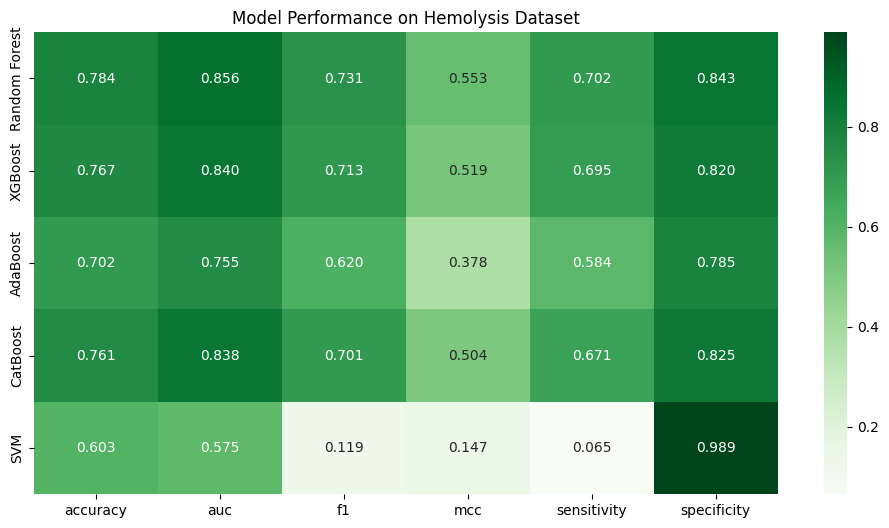

In [ ]:
# Hemolysis verisini oku
df_hem = pd.read_csv("LLM_classifier/GPT-3_deprecated/data/hemolysis_clean.csv")
df_hem = df_hem[["sequence", "label"]]  # Gerekli sütunları al
df_hem = df_hem.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Özellik çıkarımı
features_hem = df_hem["sequence"].apply(extract_basic_features)
features_hem_df = pd.DataFrame(features_hem.tolist())
df_hem_features = pd.concat([features_hem_df, df_hem["label"]], axis=1)

# Giriş ve çıkış verisi
X_hem = df_hem_features.drop("label", axis=1)
y_hem = df_hem_features["label"]

# Model listesi
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Eğitim ve sonuç
results_hem = {}
for name, model in models.items():
    print(f"\nTraining on Hemolysis: {name}")
    metrics = evaluate_model(model, X_hem, y_hem)
    results_hem[name] = metrics

# Görselleştirme
results_hem_df = pd.DataFrame(results_hem).T
results_hem_df = results_hem_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(results_hem_df, annot=True, cmap="Greens", fmt=".3f")
plt.title("Model Performance on Hemolysis Dataset")
print(results_hem_df)
plt.show()



Cross-Dataset Testing (Train: AMP → Test: Hemolysis): Random Forest

Cross-Dataset Testing (Train: AMP → Test: Hemolysis): XGBoost

Cross-Dataset Testing (Train: AMP → Test: Hemolysis): AdaBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Cross-Dataset Testing (Train: AMP → Test: Hemolysis): CatBoost

Cross-Dataset Testing (Train: AMP → Test: Hemolysis): SVM
               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.413351  0.439264  0.558403 -0.065132     0.889714   
XGBoost        0.400088  0.447465  0.560415 -0.116162     0.917285   
AdaBoost       0.412467  0.437000  0.581681 -0.059419     0.979852   
CatBoost       0.402299  0.433310  0.568602 -0.115194     0.944857   
SVM            0.416888  0.476259  0.588456  0.000000     1.000000   

               specificity  
Random Forest     0.072782  
XGBoost           0.030326  
AdaBoost          0.006823  
CatBoost          0.014405  
SVM               0.000000  


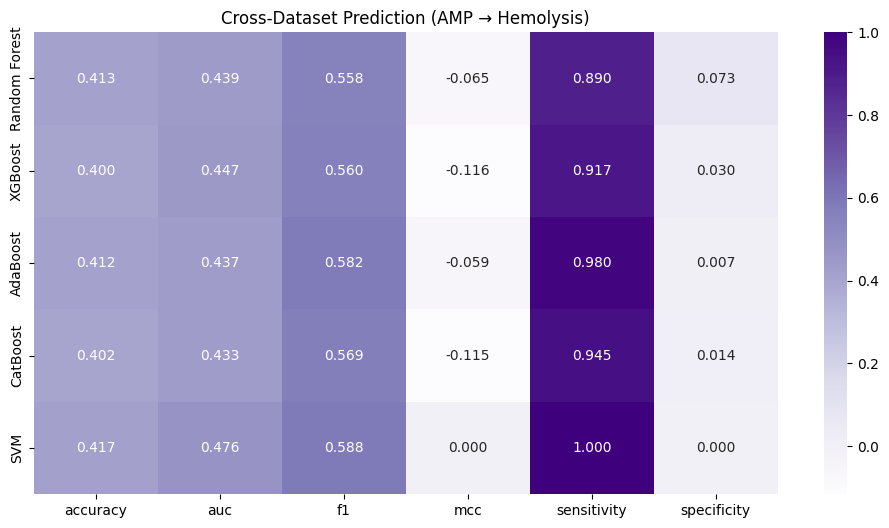

In [ ]:
# AMP verisi için giriş ve çıkışları tanımla
X_amp = df_features.drop("label", axis=1)
y_amp = df_features["label"]

cross_results = {}

for name, model in models.items():
    print(f"\nCross-Dataset Testing (Train: AMP → Test: Hemolysis): {name}")

    model.fit(X_amp, y_amp)  # AMP verisinde eğitim
    y_pred = model.predict(X_hem)
    y_prob = model.predict_proba(X_hem)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_hem, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    cross_results[name] = {
        "accuracy": accuracy_score(y_hem, y_pred),
        "f1": f1_score(y_hem, y_pred),
        "auc": roc_auc_score(y_hem, y_prob),
        "mcc": matthews_corrcoef(y_hem, y_pred),
        "sensitivity": sensitivity,
        "specificity": specificity
    }


# Görselleştirme
cross_results_df = pd.DataFrame(cross_results).T
cross_results_df = cross_results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(cross_results_df, annot=True, cmap="Purples", fmt=".3f")
plt.title("Cross-Dataset Prediction (AMP → Hemolysis)")
print(cross_results_df)
plt.show()


In [ ]:
cross_reverse_results = {}

for name, model in models.items():
    print(f"\nCross-Dataset Testing (Train: Hemolysis → Test: AMP): {name}")

    model.fit(X_hem, y_hem)  # Hemolysis verisinde eğitim
    y_pred = model.predict(X_amp)  # AMP verisinde tahmin
    y_prob = model.predict_proba(X_amp)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_amp, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    cross_reverse_results[name] = {
        "accuracy": accuracy_score(y_amp, y_pred),
        "f1": f1_score(y_amp, y_pred),
        "auc": roc_auc_score(y_amp, y_prob),
        "mcc": matthews_corrcoef(y_amp, y_pred),
        "sensitivity": sensitivity,
        "specificity": specificity
    }



Cross-Dataset Testing (Train: Hemolysis → Test: AMP): Random Forest

Cross-Dataset Testing (Train: Hemolysis → Test: AMP): XGBoost

Cross-Dataset Testing (Train: Hemolysis → Test: AMP): AdaBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Cross-Dataset Testing (Train: Hemolysis → Test: AMP): CatBoost

Cross-Dataset Testing (Train: Hemolysis → Test: AMP): SVM


               accuracy       auc        f1       mcc  sensitivity  \
Random Forest  0.432576  0.410438  0.554569 -0.113217     0.435428   
XGBoost        0.436347  0.404532  0.560470 -0.117020     0.443007   
AdaBoost       0.456267  0.393676  0.582909 -0.099704     0.468371   
CatBoost       0.429953  0.400878  0.551760 -0.116578     0.432498   
SVM            0.217067  0.417108  0.126726 -0.113571     0.070028   

               specificity  
Random Forest     0.420321  
XGBoost           0.407729  
AdaBoost          0.404255  
CatBoost          0.419019  
SVM               0.848893  


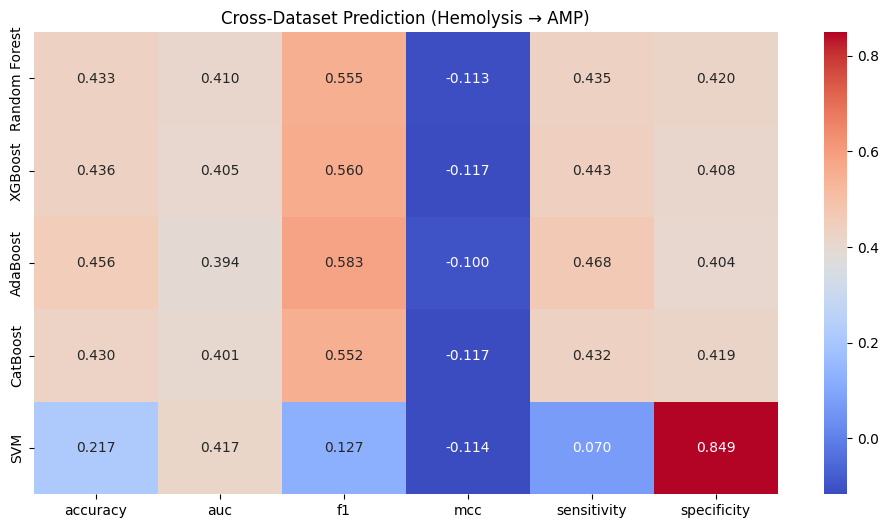

In [ ]:
cross_reverse_df = pd.DataFrame(cross_reverse_results).T
cross_reverse_df = cross_reverse_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(cross_reverse_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Cross-Dataset Prediction (Hemolysis → AMP)")
print(cross_reverse_df)
plt.show()


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from protlearn.features import aac, ngram, ctd
import pandas as pd
import numpy as np
import re

def clean_sequence(seq):
    """Dizedeki geçersiz karakterleri temizler (örn. -NH2, boşluk)."""
    seq = re.sub(r'-NH2$', '', seq)  # -NH2 kaldır
    seq = seq.replace(' ', '')  # Boşlukları kaldır
    seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])  # Geçerli amino asitler
    return seq

def extract_extended_features(seq):
    seq = clean_sequence(seq)

    # Dizi boşsa veya çok kısaysa temel özelliklerle devam et
    if not seq:
        print(f"Empty sequence after cleaning: {seq}")
        return None

    try:
        # Sequence-Based Özellikler (BioPython)
        analysis = ProteinAnalysis(seq)
        seq_features = {
            "length": len(seq),
            "molecular_weight": analysis.molecular_weight(),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "isoelectric_point": analysis.isoelectric_point(),
            "gravy": analysis.gravy()
        }

        # Kısa diziler için sadece temel özellikleri döndür
        if len(seq) < 2:
            print(f"Short sequence (len={len(seq)}): {seq}")
            return seq_features

        # Structure-Based Özellikler (protlearn - CTD)
        ctd_features, _ = ctd(seq)
        ctd_dict = {f"ctd_{i}": val for i, val in enumerate(ctd_features.flatten())}

        # Linguistic-Based Özellikler (protlearn - AAC ve N-gram)
        aac_features, _ = aac(seq, method='relative')
        aac_dict = {f"aac_{aa}": val for aa, val in zip('ACDEFGHIKLMNPQRSTVWY', aac_features)}

        ngram_features, _ = ngram(seq, n=2)  # 2-gram özellikleri
        ngram_dict = {f"ngram_{i}": val for i, val in enumerate(ngram_features.flatten())}

        # Tüm özellikleri birleştir
        features = {**seq_features, **ctd_dict, **aac_dict, **ngram_dict}
        return features
    except Exception as e:
        print(f"Error processing sequence {seq}: {e}")
        return None

# Özellikleri çıkar ve hatalı dizileri temizle
features = df_all["sequence"].apply(extract_extended_features)
valid_indices = [i for i, f in enumerate(features) if f is not None]
valid_features = [f for f in features if f is not None]

# Geçerli veri setini oluştur
df_features_extended = pd.DataFrame(valid_features)
df_features_extended["label"] = df_all["label"].iloc[valid_indices].reset_index(drop=True)

# NaN değerleri sıfırla doldur
df_features_extended = df_features_extended.fillna(0)

# Güncellenmiş X ve y
X = df_features_extended.drop("label", axis=1)
y = df_features_extended["label"]

# Özellik sayısını ve veri seti boyutunu kontrol et
print(f"Extracted features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Short sequence (len=1): V
Short sequence (len=1): K
Short sequence (len=1): F
Extracted features shape: (12199, 750)
Labels shape: (12199,)


Checking X for invalid data types...
Column aac_A contains lists/arrays. Converting to scalar.
Data types in X_cleaned:
float64    749
int64        1
Name: count, dtype: int64

Training: Random Forest

Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training: AdaBoost

Training: CatBoost

Training: SVM

Training: LogitBoost_Alternative


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py

                        accuracy       auc        f1       mcc  sensitivity  \
Random Forest           0.844249  0.844296  0.909248  0.401951     0.961903   
XGBoost                 0.847365  0.832178  0.910291  0.427290     0.954729   
AdaBoost                0.817444  0.748088  0.896920  0.203765     0.979083   
CatBoost                0.843922  0.838293  0.909641  0.391503     0.968472   
SVM                     0.811214  0.461441  0.895768  0.000000     1.000000   
LogitBoost_Alternative  0.817444  0.748088  0.896920  0.203765     0.979083   

                        specificity  
Random Forest              0.338689  
XGBoost                    0.386023  
AdaBoost                   0.122891  
CatBoost                   0.308733  
SVM                        0.000000  
LogitBoost_Alternative     0.122891  


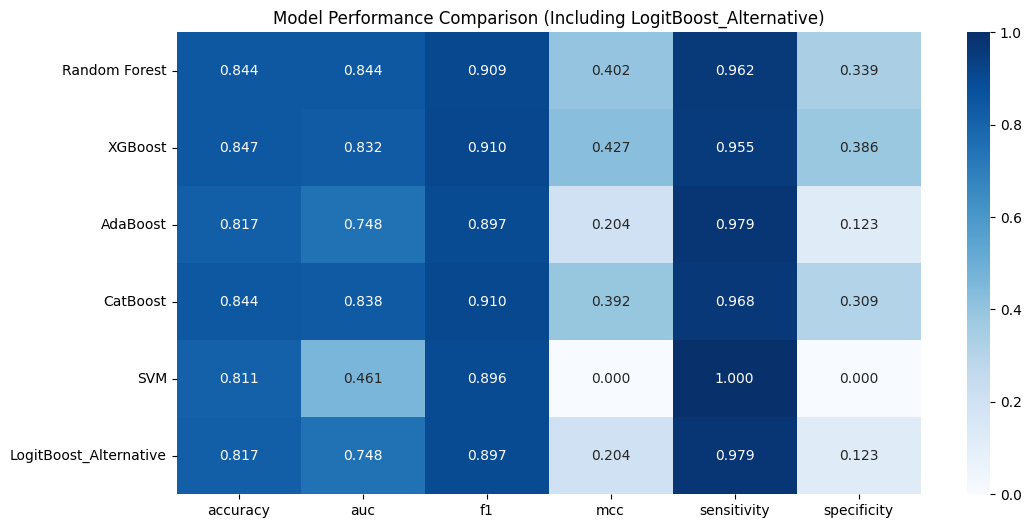

In [ ]:
import pandas as pd
import numpy as np

# Veri setini kontrol et ve temizle
def check_and_clean_features(df):
    """Sütunlarda liste/dizi olup olmadığını kontrol eder ve düzeltir."""
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
            print(f"Column {col} contains lists/arrays. Converting to scalar.")
            # Liste/dizi içeren sütunları skaler değere dönüştür (örneğin, ilk elemanı al)
            df[col] = df[col].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
    return df

# Özellik matrisini temizle
print("Checking X for invalid data types...")
X_cleaned = check_and_clean_features(X.copy())
X_cleaned = X_cleaned.fillna(0)  # NaN değerleri sıfırla

# Veri türlerini kontrol et
print("Data types in X_cleaned:")
print(X_cleaned.dtypes.value_counts())

# scikit-learn'ü uyumlu bir sürüme güncelle
!pip install scikit-learn==1.5.0 --quiet

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# LogitBoost yerine AdaBoost ile SAMME algoritması
models["LogitBoost_Alternative"] = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Zayıf öğrenici
    n_estimators=100,
    algorithm="SAMME",  # LogitBoost benzeri davranış
    random_state=42
)

# Eğitim döngüsü
results = {}
for name, model in models.items():
    print(f"\nTraining: {name}")
    try:
        metrics = evaluate_model(model, X_cleaned, y, k=5)
        results[name] = metrics
    except Exception as e:
        print(f"Error training {name}: {e}")

# Sonuçları görselleştir
import matplotlib.pyplot as plt
import seaborn as sns
results_df = pd.DataFrame(results).T
results_df = results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison (Including LogitBoost_Alternative)")
print(results_df)
plt.show()

RFE future selection

Running RFE feature selection...
RFE Selected Features: ['length', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'gravy', 'aac_A', 'ngram_168', 'ngram_188', 'ngram_189']

Running Mutual Information feature selection...
Mutual Information Selected Features: ['molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'gravy', 'ctd_81', 'ctd_225', 'ctd_267', 'ngram_0', 'ngram_227']

Training with RFE features: Random Forest

Training with RFE features: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training with RFE features: AdaBoost

Training with RFE features: CatBoost

Training with RFE features: SVM

Training with RFE features: LogitBoost_Alternative


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py


Training with Mutual Information features: Random Forest

Training with Mutual Information features: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training with Mutual Information features: AdaBoost

Training with Mutual Information features: CatBoost

Training with Mutual Information features: SVM

Training with Mutual Information features: LogitBoost_Alternative


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py

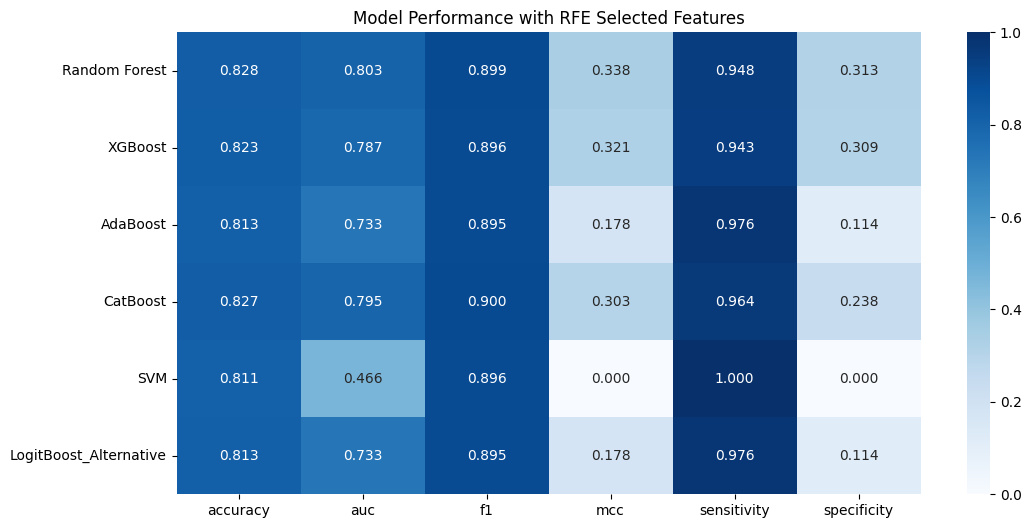


RFE Performance Results:
                        accuracy       auc        f1       mcc  sensitivity  \
Random Forest           0.827937  0.802921  0.899358  0.338186     0.947756   
XGBoost                 0.822855  0.787207  0.896170  0.321275     0.942502   
AdaBoost                0.813428  0.732805  0.894612  0.177956     0.976152   
CatBoost                0.827117  0.795400  0.900475  0.302613     0.964127   
SVM                     0.811214  0.465804  0.895768  0.000000     1.000000   
LogitBoost_Alternative  0.813428  0.732805  0.894612  0.177956     0.976152   

                        specificity  
Random Forest              0.313058  
XGBoost                    0.308728  
AdaBoost                   0.114206  
CatBoost                   0.238381  
SVM                        0.000000  
LogitBoost_Alternative     0.114206  


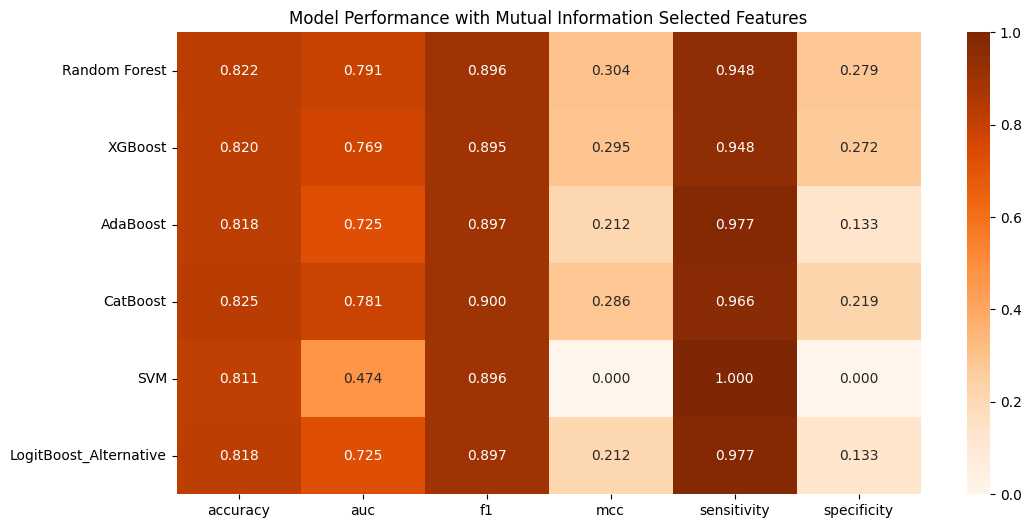


Mutual Information Performance Results:
                        accuracy       auc        f1       mcc  sensitivity  \
Random Forest           0.822035  0.791188  0.896331  0.304424     0.948464   
XGBoost                 0.820150  0.769027  0.895279  0.294818     0.947656   
AdaBoost                0.817936  0.725188  0.897000  0.211766     0.977263   
CatBoost                0.825150  0.781432  0.899648  0.286476     0.966148   
SVM                     0.811214  0.474399  0.895768  0.000000     1.000000   
LogitBoost_Alternative  0.817936  0.725188  0.897000  0.211766     0.977263   

                        specificity  
Random Forest              0.278767  
XGBoost                    0.272271  
AdaBoost                   0.133315  
CatBoost                   0.219286  
SVM                        0.000000  
LogitBoost_Alternative     0.133315  


In [ ]:
# Gerekli kütüphaneleri yükle
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RFE ile özellik seçimi (Random Forest tabanlı)
print("Running RFE feature selection...")
rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=10,  # En iyi 10 özelliği seç
    step=10  # Her adımda 10 özelliği eler
)
X_rfe = rfe_selector.fit_transform(X_cleaned, y)
selected_features_rfe = X_cleaned.columns[rfe_selector.get_support()].tolist()
print("RFE Selected Features:", selected_features_rfe)

# Mutual Information ile özellik seçimi
print("\nRunning Mutual Information feature selection...")
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)  # En iyi 10 özelliği seç
X_mi = mi_selector.fit_transform(X_cleaned, y)
selected_features_mi = X_cleaned.columns[mi_selector.get_support()].tolist()
print("Mutual Information Selected Features:", selected_features_mi)

# RFE ile seçilen özelliklerle modelleri değerlendir
X_rfe_df = pd.DataFrame(X_rfe, columns=selected_features_rfe)
rfe_results = {}
for name, model in models.items():
    print(f"\nTraining with RFE features: {name}")
    try:
        metrics = evaluate_model(model, X_rfe_df, y, k=5)
        rfe_results[name] = metrics
    except Exception as e:
        print(f"Error training {name} with RFE features: {e}")

# Mutual Information ile seçilen özelliklerle modelleri değerlendir
X_mi_df = pd.DataFrame(X_mi, columns=selected_features_mi)
mi_results = {}
for name, model in models.items():
    print(f"\nTraining with Mutual Information features: {name}")
    try:
        metrics = evaluate_model(model, X_mi_df, y, k=5)
        mi_results[name] = metrics
    except Exception as e:
        print(f"Error training {name} with MI features: {e}")

# Sonuçları görselleştir
# RFE Sonuçları
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df = rfe_results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]
plt.figure(figsize=(12, 6))
sns.heatmap(rfe_results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance with RFE Selected Features")
plt.show()

print("\nRFE Performance Results:")
print(rfe_results_df)

# Mutual Information Sonuçları
mi_results_df = pd.DataFrame(mi_results).T
mi_results_df = mi_results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]
plt.figure(figsize=(12, 6))
sns.heatmap(mi_results_df, annot=True, cmap="Oranges", fmt=".3f")
plt.title("Model Performance with Mutual Information Selected Features")
plt.show()

print("\nMutual Information Performance Results:")
print(mi_results_df)

hiper parametre ayarı


Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Tuning hyperparameters for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:41:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

Tuning hyperparameters for AdaBoost...
Error tuning AdaBoost: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", li

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for CatBoost: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 1.0, 'kernel': 'rbf'}

Tuning hyperparameters for LogitBoost_Alternative...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):


Best parameters for LogitBoost_Alternative: {'learning_rate': 1.0, 'n_estimators': 100}

Training tuned model: Random Forest

Training tuned model: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Training tuned model: AdaBoost

Training tuned model: CatBoost

Training tuned model: SVM

Training tuned model: LogitBoost_Alternative


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  def _validate_estimator(self):
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py

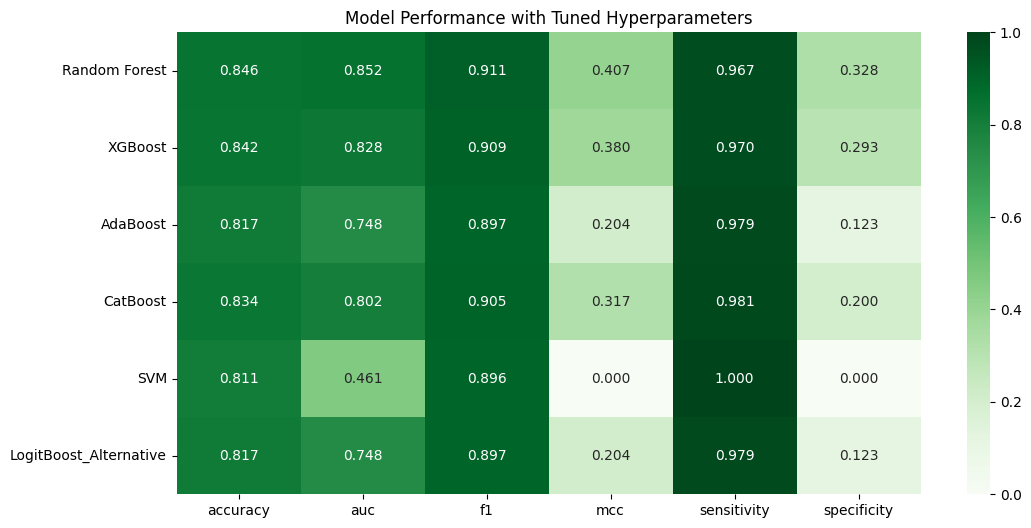


Tuned Model Performance Results:
                        accuracy       auc        f1       mcc  sensitivity  \
Random Forest           0.846381  0.851842  0.910804  0.406785     0.966956   
XGBoost                 0.842037  0.827831  0.908763  0.379677     0.969785   
AdaBoost                0.817444  0.748088  0.896920  0.203765     0.979083   
CatBoost                0.833675  0.802334  0.905402  0.316540     0.981204   
SVM                     0.811214  0.461441  0.895768  0.000000     1.000000   
LogitBoost_Alternative  0.817444  0.748088  0.896920  0.203765     0.979083   

                        specificity  
Random Forest              0.328265  
XGBoost                    0.293101  
AdaBoost                   0.122891  
CatBoost                   0.199744  
SVM                        0.000000  
LogitBoost_Alternative     0.122891  


In [ ]:
# Gerekli kütüphaneleri yükle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hiperparametre grid'leri
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [50, 100],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    "AdaBoost": {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 1.0]
    },
    "CatBoost": {
        'iterations': [50, 100],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1]
    },
    "SVM": {
        'C': [0.1, 1.0],
        'kernel': ['rbf']
    },
    "LogitBoost_Alternative": {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 1.0]
    }
}

# Optimize edilmiş modelleri saklamak için dictionary
tuned_models = {}

# Hiperparametre ayarı
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=3,  # 3 katlı çapraz doğrulama
            scoring='roc_auc',  # AUC skoru ile optimize et
            n_jobs=-1,  # Tüm CPU çekirdeklerini kullan
            verbose=0
        )
        grid_search.fit(X_cleaned, y)
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        tuned_models[name] = grid_search.best_estimator_
    except Exception as e:
        print(f"Error tuning {name}: {e}")
        tuned_models[name] = model  # Hata durumunda orijinal modeli kullan

# Optimize edilmiş modellerle değerlendirme
tuned_results = {}
for name, model in tuned_models.items():
    print(f"\nTraining tuned model: {name}")
    try:
        metrics = evaluate_model(model, X_cleaned, y, k=5)
        tuned_results[name] = metrics
    except Exception as e:
        print(f"Error training tuned {name}: {e}")

# Sonuçları görselleştir
tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df = tuned_results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]

plt.figure(figsize=(12, 6))
sns.heatmap(tuned_results_df, annot=True, cmap="Greens", fmt=".3f")
plt.title("Model Performance with Tuned Hyperparameters")
plt.show()

print("\nTuned Model Performance Results:")
print(tuned_results_df)